# Машинное обучение, ФКН ВШЭ

## Практическое задание 3

### Общая информация
Дата выдачи: 27.11.2017  

Мягкий дедлайн: 23:59MSK 14.12.2017 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 17.12.2017  

### О задании

Задание состоит из трех независимых разделов, посвященных bias-variance decomposition, решающим деревьям и композициям алгоритмов. Эти разделы можно выполнять в любом порядке. В каждом разделе вам предложена одна или две задачи, которые, в свою очередь, делятся на пункты. Баллы даются за выполнение пунктов, причем в рамках одной задачи пункты, как правило, зависимы (нельзя решить следующий, не решив предыдущего). Пункты могут быть двух видов: написать скрипт или ответить на вопросы. Задачи в рамках одного раздела рекомендуется решать в том порядке, в котором они даны в задании. В разных задачах используются разные наборы данных, все наборы взяты из репозитория UCI или из соревнования с платформы kaggle. 

Задание направлено на более глубокое ознакомление с тем, как работают решающие деревья, случайные леса и как устроено разложение на смещение и разброс. Кроме того, задание предполагает проведение экспериментов и анализ их результатов (мини-исследования). 

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Почта: hse.cs.ml+<номер группы>@gmail.com (например, hse.cs.ml+151@gmail.com для студентов группы БПМИ-151)

Пришлите на почту архив homework-practice-03-Username.zip с выполненным заданием. Архив должен содержать:
* Ноутбук homework-practice-03-Username.ipynb
* Модуль hw3code.py

В контест https://contest.yandex.ru/contest/6469/problems/ нужно отправить файл hw3code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

* Ссылка на посылку в Яндекс.Контесте: https://contest.yandex.ru/contest/6469/run-report/10044943/
* Максимальная оценка: 11.5 (10 + 2 бонуса)

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

34.381901091064215

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.917591126761806

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
##### Задача 1. Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1. (0.3 балла)__  #done
1. Сгенерируйте выборку $x$ из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных $y$ как сумму $f(x)$ и случайного шума, сгенерированного из равномерного распределения на отрезке $[-1, 1]$ (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: $f(x)$ и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).
    
<a id='hello_cat'></a>
[назад](#return) (just ignore that)

In [14]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


   ☆
☆       ☆  ／￣￣￣￣￣￣￣￣
    ☽      |　   Hello!
       ☆   ＼＿　 ＿＿＿＿＿＿
 ☆   　　　　   ∨
       /ᐠ Ф ﻌ Ф ᐟ\ﾉ
       


In [18]:
x = np.random.exponential(size=sample_size)
y = f(x) + np.random.uniform(low=-1.0, high=1.0, size=sample_size)

from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor()
regr.fit(x[:, np.newaxis], y)
pred = regr.predict(linspace[:, np.newaxis])

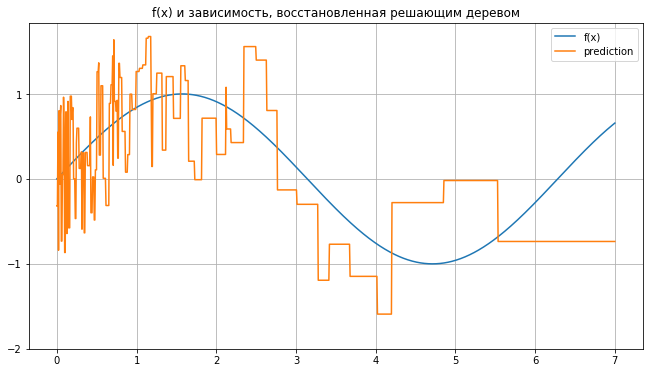

In [42]:
plt.plot(linspace, f(linspace), label="f(x)")
plt.plot(linspace, pred, label="prediction")
plt.title(u"f(x) и зависимость, восстановленная решающим деревом")
plt.yticks(np.arange(-2, 2))
plt.grid()
plt.legend()
plt.rcParams["figure.figsize"] = (11,6)

plt.show()

In [16]:
?np.random.uniform

__2. (0.3 балла)__ #done

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").

<a id='another_cat'></a>
[назад](#return)

In [83]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

               ✿
 ✿ — (≈චᆽච≈) ﾉ



In [86]:
X = []
Y = []
P = []

for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    y = f(x) + np.random.uniform(low=-1.0, high=1.0, size=sample_size)
    regr = DecisionTreeRegressor()
    regr.fit(x[:, np.newaxis], y)
    pred = regr.predict(linspace[:, np.newaxis])
    X.append(x)
    Y.append(y)
    P.append(pred)

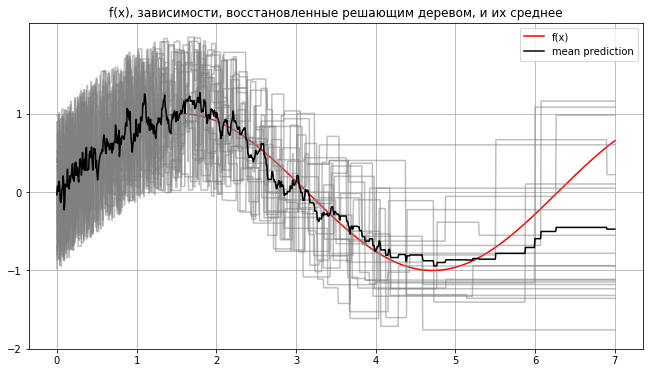

In [98]:
plt.plot(linspace, f(linspace), color="red", label="f(x)")

for i in range(samples_num):
    plt.plot(linspace, P[i], color="gray", alpha=0.5)
    
plt.plot(linspace, np.array(P).mean(axis=0), color="black", label="mean prediction")
plt.title(u"f(x), зависимости, восстановленные решающим деревом, и их среднее")
plt.yticks(np.arange(-2, 2))
plt.grid()
plt.legend()
plt.rcParams["figure.figsize"] = (11,6)

plt.show()

__3. (0.1 балла):__ #done

Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика. __Избегайте копипасты кода! Сделайте функцию, параметризованную максимальной глубиной дерева, которая отрисовывает необходимые картинки!__

In [101]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

def plot_different_depth(depth):
    X = []
    Y = []
    P = []

    for i in range(samples_num):
        x = np.random.exponential(size=sample_size)
        y = f(x) + np.random.uniform(low=-1.0, high=1.0, size=sample_size)
        regr = DecisionTreeRegressor(max_depth=depth)
        regr.fit(x[:, np.newaxis], y)
        pred = regr.predict(linspace[:, np.newaxis])
        X.append(x)
        Y.append(y)
        P.append(pred)
        
    plt.plot(linspace, f(linspace), color="red", label="f(x)")

    for i in range(samples_num):
        plt.plot(linspace, P[i], color="gray", alpha=0.5)

    plt.plot(linspace, np.array(P).mean(axis=0), color="black", label="mean prediction")
    plt.title(u"f(x), зависимости, восстановленные решающим деревом с глубиной "
              + str(depth) + u", и их среднее")
    plt.yticks(np.arange(-2, 2))
    plt.grid()
    plt.legend()
    plt.rcParams["figure.figsize"] = (11,6)

    plt.show()

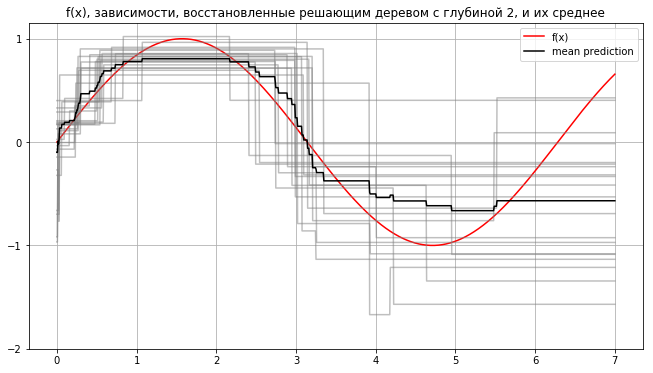

In [102]:
plot_different_depth(2)

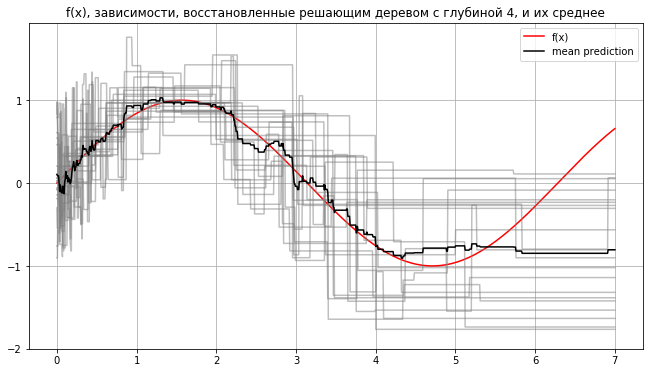

In [103]:
plot_different_depth(4)

__4. (0.3 балла)__ #done

Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

**Ответ:**
У решающих деревьев маленькое смещение.
В случае решающего дерева, не имеющего ограничения на глубину, можно утверждать, что его смещение близко к нулю.

#### Задача 2. Приближенное оценивание смещения и разброса
Реализуем стохастическую процедуру оценивания смещения и разброса алгоритма.

Будем считать, что каждый объект представлен одним признаком, сгенерированным из некоторого распределения, а значение целевой переменной на этом объекте — это сумма истинного значения функции на объекте + шумовая компонента, также сгенерированная из некоторого распределения.

__5. (1 балл) __  #done

Реализуйте функции compute_bias_variance и compute_bias_variance_fixed_samples из модуля hw3code.py

# compute_bias_variance

После генерации всех необходимых объектов, должна вызываться функция compute_bias_variance_fixed_samples.

Рекомендации:
* Создайте вектор объектов для оценивания интеграла по $x$, затем вектор зашумленных правильных ответов.
  Оцените мат. ожидание шума с помощью генерации отдельной шумовой выборки длины objects_num.
* Проверить правильность реализации можно на примерах, которые разбирались на семинаре и в домашней работе.

* :param regressor: объект sklearn-класса, реализующего регрессионный алгоритм (например, DecisionTreeRegressor,
 LinearRegression, Lasso, RandomForestRegressor ...)
* :param dependence_fun: функция, задающая истинную зависимость в данных. Принимает на вход вектор и возвращает вектор
 такой же длины. Примеры: np.sin, lambda x: x**2
* :param x_generator: функция, генерирующая одномерную выборку объектов и имеющая параметр size (число объектов в
 выборке). По умолчанию np.random.uniform
* :param noise_generator: функция, генерирующая одномерную выборку шумовых компонент (по одной на каждый объект) и
 имеющая параметр size (число объектов в выборке). По умолчанию np.random.uniform
* :param sample_size: число объектов в выборке
* :param samples_num: число выборок, которые нужно сгенерировать, чтобы оценить интеграл по X
* :param objects_num: число объектов, которые нужно сгенерировать, чтобы оценить интеграл по x
* :param seed: seed для функции np.random.seed

* :return bias: смещение алгоритма regressor (число)
* :return variance: разброс алгоритма regressor (число)

# compute_bias_variance_fixed_samples

В качестве допущения, будем оценивать $E_X\left[\mu(X)\right](x)$ как средний ответ на $x$ из samples_num
алгоритмов, обученных на своих подвыборках $X$

Рекомендации:
* $\mathbb{E}[y|x]$ оценивается как сумма правильного ответа на объекте и мат. ожидания шума
*  $\mathbb{E}_X [\mu(X)]$ оценивается как в предыдущей задаче: нужно обучить regressor на samples_num выборках длины
   sample_size и усреднить предсказания на сгенерированных ранее объектах.

* :param regressor: объект sklearn-класса, реализующего регрессионный алгоритм (например, DecisionTreeRegressor,
 LinearRegression, Lasso, RandomForestRegressor ...)
* :param dependence_fun: функция, задающая истинную зависимость в данных. Принимает на вход вектор и возвращает вектор
 такой же длины. Примеры: np.sin, lambda x: x**2
* :param samples: samples_num выборк длины sample_size для оценки интеграла по X
* :param objects: objects_num объектов для оценки интеграла по x
* :param noise: шумовая компонента размерности (samples_num, sample_size)
* :param mean_noise: среднее шумовой компоненты

* :return bias: смещение алгоритма regressor (число)
* :return variance: разброс алгоритма regressor (число)

__6. (0.4 балла)__  #done

Пусть истинная зависимость данных задается функцией $5\sin (10 x)$, а значения признаков и шум генерируются из одного и того же распределения. Будем пробовать 4 разных распределения и сравнивать 4 регрессионных алгоритма (см. таблицы ниже). Необходимо в каждую ячейку датафреймов bias и variance записать записать соответственно смещение и разброс, рассчитанные для алгоритма, задаваемого строкой таблицы, и генератора случайных чисел, задаваемого столбцом. Остальные параметры функции compute_bias_variance оставьте по умолчанию.

In [191]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [192]:
regressors = [LinearRegression(), 
              DecisionTreeRegressor(), 
              RandomForestRegressor(),
              GradientBoostingRegressor()]
generators = [lambda size: np.random.normal(0, 0.3, size=size), 
              lambda size: np.random.exponential(0.3, size=size), 
              lambda size: np.random.uniform(-1, 1, size=size),
              lambda size: np.random.uniform(0, 1, size=size)]

In [193]:
df_bias = pd.DataFrame(columns=["normal(0, 0.3)", "exponential(0.3)", "uniform(-1, 1)", "uniform(0, 1)"],
                       index=["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"])
df_variance = pd.DataFrame(columns=df_bias.columns, index=df_bias.index)

In [175]:
from importlib import reload
import hw3code

reload(hw3code)

from hw3code import wrapper, compute_bias_variance

In [173]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import re

def func(x):
    return 5*np.sin(10*x)

def count_bv(gen_type, reg_name):
    reg = LinearRegression
    if reg_name == 'DecisionTree':
        reg = DecisionTreeRegressor
    if reg_name == 'RandomForest':
        reg = RandomForestRegressor
    if reg_name == 'GradientBoosting':
        reg = GradientBoostingRegressor
    gen_params = re.split('[(,)]', gen_type)
    gen_name = gen_params[0]
    gen_p1 = float(gen_params[1])
    try:
        gen_p2 = float(gen_params[2])
    except:
        gen_p2 = 0
    wrapper.__defaults__ = (gen_p1, gen_p2)
    if gen_name == 'normal':
        gen = np.random.normal
    if gen_name == 'exponential':
        gen = np.random.exponential
    if gen_name == 'uniform':
        gen = np.random.uniform
    return compute_bias_variance(regressor=reg, dependence_fun=func, x_generator=gen, noise_generator=gen)

In [534]:
import itertools
values = {}
for i, j in itertools.product(df_bias.columns, df_bias.index):
    values.update({(i, j): count_bv(i, j)})

In [535]:
for col in df_bias.columns:
    for row in df_bias[col].index:
        df_bias[col][row] = round(values[col, row][0], 4)
        df_variance[col][row] = round(values[col, row][1], 4)

In [536]:
df_bias

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,12.1799,7.0964,11.7468,12.0447
DecisionTree,0.0752,0.0896,0.0022,0.0006
RandomForest,0.0846,0.1343,0.0021,0.0007
GradientBoosting,0.0763,0.0932,0.0125,0.0013


In [537]:
df_variance

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,0.0859,0.0768,0.0756,0.058
DecisionTree,0.1714,0.2296,0.3605,0.09
RandomForest,0.0973,0.1332,0.1957,0.0487
GradientBoosting,0.1136,0.1621,0.1438,0.0394


__7. (0.6 балла)__ #done

Проанализируйте полученные таблицы. Ответьте на вопросы:
* Отранжируйте алгоритмы в порядке увеличения разброса (если какие-то алгоримты в разных случаях ранжируются по-разному, поставьте их на одну ступень). Согласуется ли полученный результат с теоретическими рассуждениями из лекций (поясните, почему да или нет)?

In [538]:
df_variance.sort_values(by=list(df_variance.columns))

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,0.0859,0.0768,0.0756,0.058
RandomForest,0.0973,0.1332,0.1957,0.0487
GradientBoosting,0.1136,0.1621,0.1438,0.0394
DecisionTree,0.1714,0.2296,0.3605,0.09


**Ответ:** 

* Можно ли сказать, что смещение и разброс алгоритма определяются только самим алгоритмом и не зависят от вероятностной модели данных, к которым этот алгоритм применяется (поясните, почему да или нет)? 

Нет, это видно по столбцам полученных таблиц -- для разных вероятностных моделей данных получаются немного разные смещение и разброс. Сильнее всего для каждого алгоритма от остальных полученных значений отличаются значения из столбца uniform(0, 1).

* Для каких распределений смещение решающих деревьев велико (по сравнению с другими распределениями)? Как вы думаете, почему так происходит (какие особенности этих распределений приводят к большому смещению)?

Для нормального и экспоненциального. Дело в том, что для этих распределений очевидно будет меньше разброс. Из-за того, что для них разброс меньше, смещение становится больше.

__8. (бонус, 0.5 балла)__ #done

Постройте графики зависимости смещения и разброса от sample_size, samples_num и objects_num (при варьировании одного параметра остальные два остаются по умолчанию) для четырех рассмотренных регрессионных алгоритмов. Сделайте выводы о том, как эти параметры влияют на дисперсию оценок.

In [537]:
val_range = np.arange(10, 1100, 200)
val_range[1:] -= 10

def compute_values(regr):
    res_sam_size = []
    res_sam_num = []
    res_obj_num = []

    for val in val_range:
        res_sam_size.append(compute_bias_variance(regr, dependence_fun=func, sample_size=val))
        res_sam_num.append(compute_bias_variance(regr, dependence_fun=func, samples_num=val))
        res_obj_num.append(compute_bias_variance(regr, dependence_fun=func, objects_num=val))
    return np.array(res_sam_size), np.array(res_sam_num), np.array(res_obj_num)

In [229]:
def plot_results(arr1, arr2, arr3, algname, valname):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 5))

    ax1.plot(val_range, arr1)
    ax2.plot(val_range, arr2)
    ax3.plot(val_range, arr3)

    plt.suptitle(algname, size=20)
    ax1.set_ylabel(valname)
    ax1.set_xlabel("sample_size")
    ax1.grid()
    ax1.legend()

    ax2.set_ylabel(valname)
    ax2.set_xlabel('samples_num')
    ax2.grid()
    ax2.legend()

    ax3.set_ylabel(valname)
    ax3.set_xlabel('objects_num')
    ax3.grid()
    ax3.legend()
    
    allval = np.concatenate([arr1, arr2, arr3])
    maxval = int(allval.max()) + 1.5
    minval = int(allval.min())
    ax1.set_yticks(np.arange(minval, maxval, 0.5))
    ax2.set_yticks(np.arange(minval, maxval, 0.5))
    ax3.set_yticks(np.arange(minval, maxval, 0.5))

    f.show()

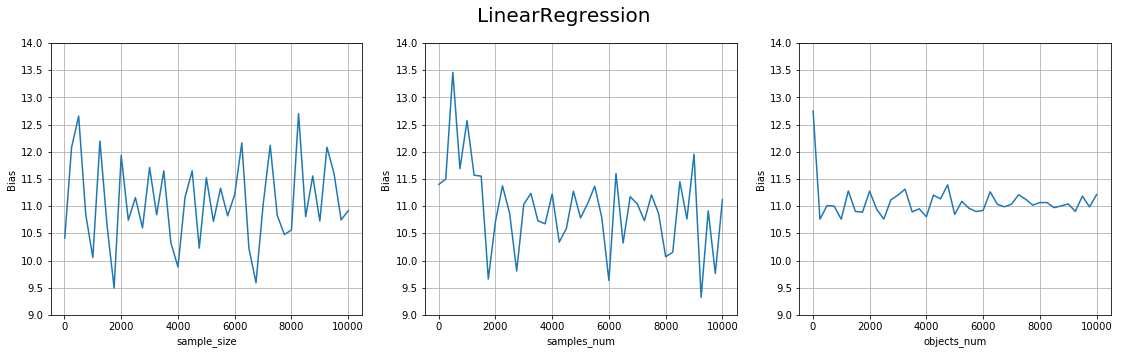

In [232]:
plot_results(res_sam_size[:,0], res_sam_num[:,0], res_obj_num[:,0], "LinearRegression", "Bias")

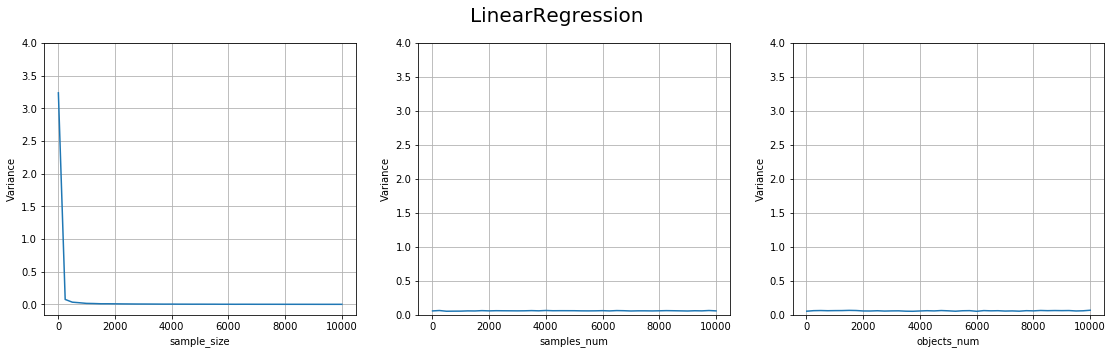

In [233]:
plot_results(res_sam_size[:,1], res_sam_num[:,1], res_obj_num[:,1], "LinearRegression", "Variance")

In [434]:
vals = compute_values(DecisionTreeRegressor)

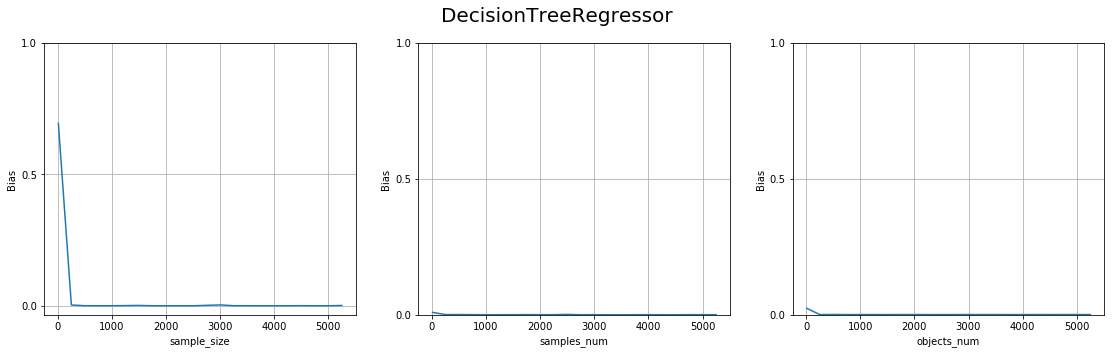

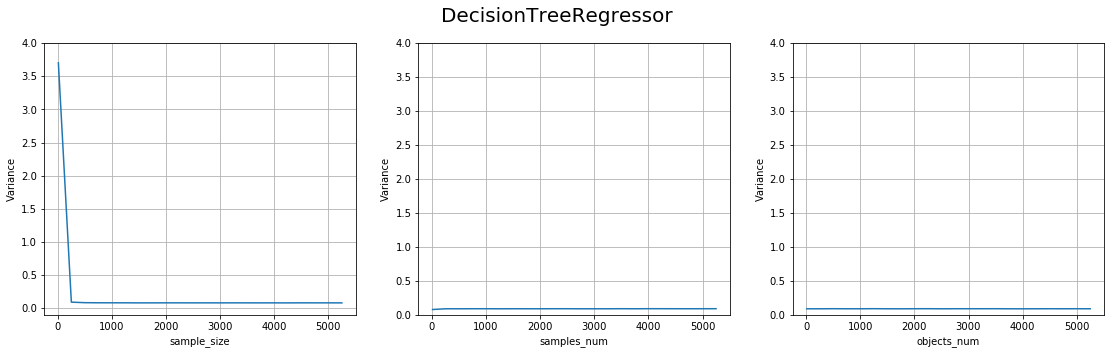

In [435]:
plot_results(vals[0][:,0], vals[1][:,0], vals[2][:,0], "DecisionTreeRegressor", "Bias")
plot_results(vals[0][:,1], vals[1][:,1], vals[2][:,1], "DecisionTreeRegressor", "Variance")

In [534]:
vals = compute_values(RandomForestRegressor)

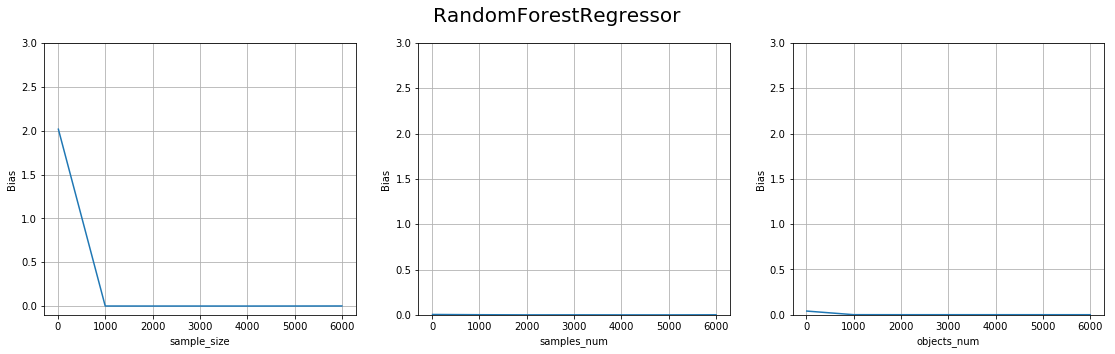

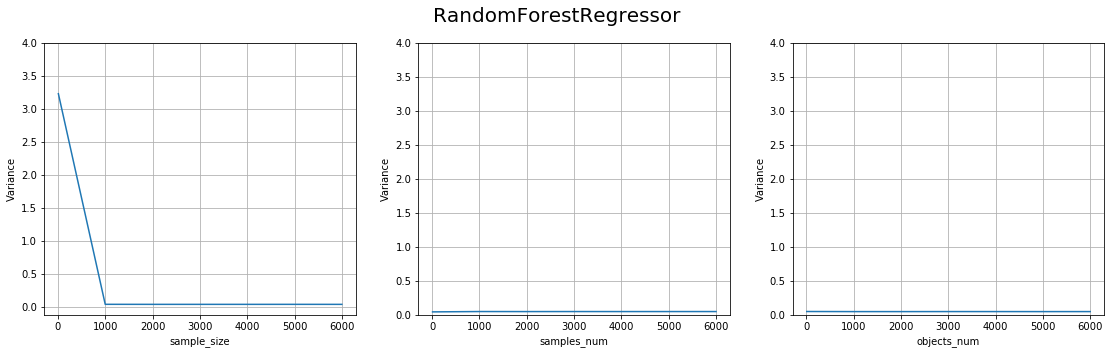

In [535]:
plot_results(vals[0][:,0], vals[1][:,0], vals[2][:,0], "RandomForestRegressor", "Bias")
plot_results(vals[0][:,1], vals[1][:,1], vals[2][:,1], "RandomForestRegressor", "Variance")

In [538]:
vals = compute_values(GradientBoostingRegressor)

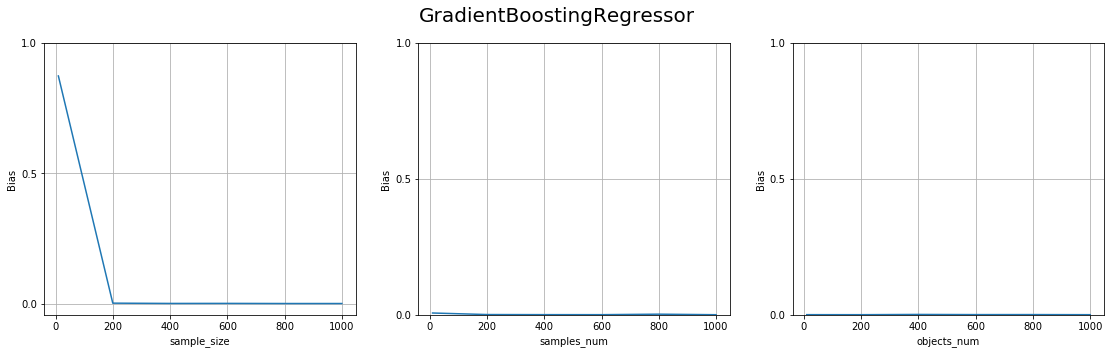

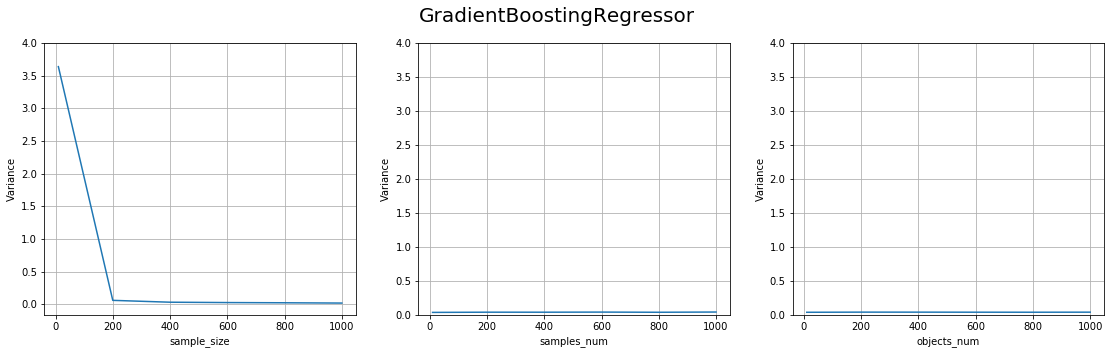

In [539]:
plot_results(vals[0][:,0], vals[1][:,0], vals[2][:,0], "GradientBoostingRegressor", "Bias")
plot_results(vals[0][:,1], vals[1][:,1], vals[2][:,1], "GradientBoostingRegressor", "Variance")

### II. Решающие деревья своими руками

#### Задача 3.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__9. (0.5 балла)__ #done

Реализуйте функцию find_best_split из модуля hw3code.py

Под критерием Джини здесь подразумевается следующая функция:
$$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
$R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
 $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.

Указания:
* Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
* В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
* Поведение функции в случае константного признака может быть любым.
* При одинаковых приростах Джини нужно выбирать минимальный сплит.
* За наличие в функции циклов балл будет снижен. Векторизуйте! :)


* :param feature_vector: вещественнозначный вектор значений признака
* :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)

* :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
 разделить на две различные подвыборки, или поддерева
* :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
* :return threshold_best: оптимальный порог (число)
* :return gini_best: оптимальное значение критерия Джини (число)

In [378]:
from importlib import reload
import hw3code

reload(hw3code)

<module 'hw3code' from '/Users/masha/Documents/9/ml/prac/3/hw3code.py'>

In [379]:
from hw3code import *

__10. (0.5 балла)__ #done

Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [243]:
import pandas as pd
students = pd.read_csv('students.csv')
students.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [252]:
students = pd.read_csv('students.csv')
target = np.array(students[students.columns[-1]])
data = np.array(students[students.columns[:-1]])

In [262]:
splits = []
for i in range(data.shape[1]):
    split = find_best_split(data[:, i], target)
    splits.append(split)

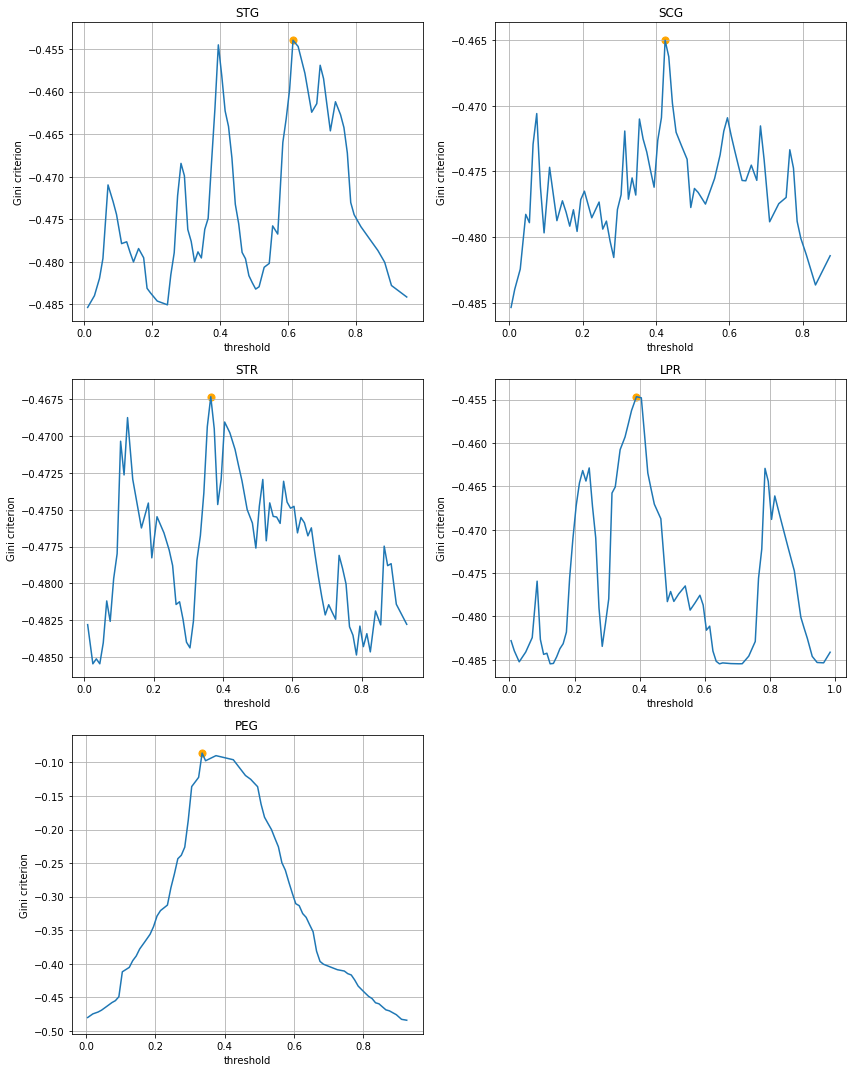

In [310]:
subplots = plt.subplots(3, 2, figsize=(12, 15))
f = subplots[0]
ax1, ax2, ax3, ax4, ax5, ax6 = subplots[1].ravel()

axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i, split in enumerate(splits):
    axes[i].plot(split[0], split[1])
    axes[i].scatter(split[2], split[3], s=50, color='orange')
    axes[i].set_title(students.columns[i])
    axes[i].set_ylabel("Gini criterion")
    axes[i].set_xlabel("threshold")
    axes[i].grid()
    axes[i].legend()
    
axes[-1].set_visible(False)
f.tight_layout()
f.show()

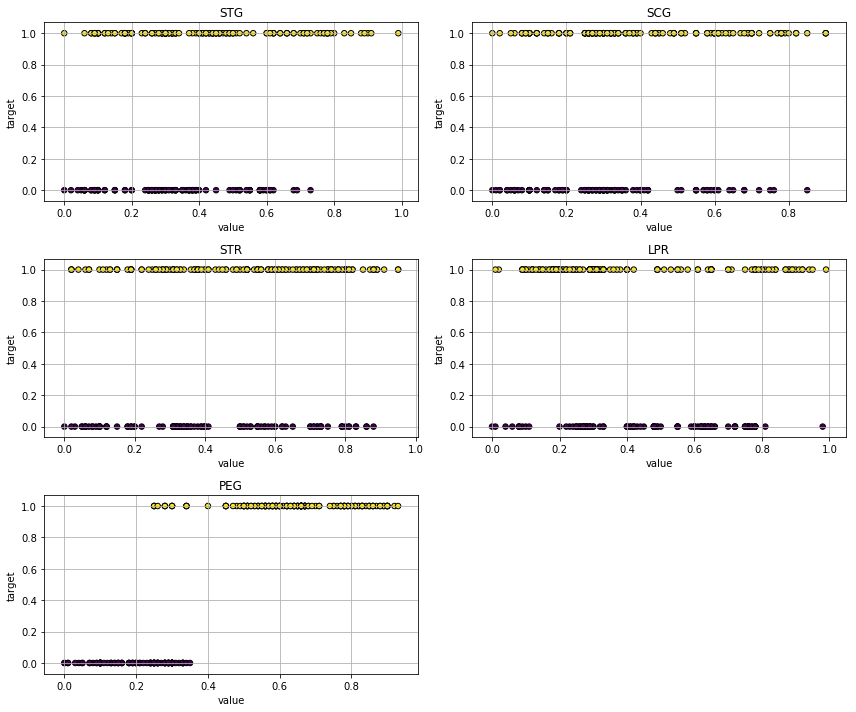

In [318]:
subplots = plt.subplots(3, 2, figsize=(12, 10))
f = subplots[0]
ax1, ax2, ax3, ax4, ax5, ax6 = subplots[1].ravel()

axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i, split in enumerate(splits):
    axes[i].scatter(data[:,i], target, c=target, s=30, edgecolors='black')
    axes[i].set_title(students.columns[i])
    axes[i].set_ylabel("target")
    axes[i].set_xlabel("value")
    axes[i].grid()
    axes[i].legend()
    
axes[-1].set_visible(False)
f.tight_layout()
f.show()

__11. (0.5 балла)__ #done

**Ответ:**

* Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева?

Однозначно по PEG.

* Согласуется ли этот результат с визуальной оценкой scatter-графиков?

Да, согласуется, так как даже на scatter plot'e для PEG можно увидеть, что по этому признаку данные разделяются лучше всего.

* Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально?

Кривая с малым количеством локальных максимумов, желательно монотонно возрастающая практически до глобального максимума, и монотонно убывающая практически везде после него. 

* Чем отличаются кривые для признаков, по которым деление практически невозможно?

Большим количеством локальных экстремумов, областями монотонности на совсем небольших отрезках по x (значению порога).

__12. (1.5 балла).__ #done

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw3code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__13. (0.5 балла)__ #done

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [321]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

mushrooms = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', names=np.hstack((np.array(['mushroom type']), np.arange(1, 23).astype(np.string_))))
target = np.array(mushrooms[mushrooms.columns[0]])
data = np.array(mushrooms[mushrooms.columns[1:]])

lab_enc = LabelEncoder()
target = lab_enc.fit_transform(target)
for i in range(data.shape[1]):
    data[:, i] = lab_enc.fit_transform(data[:, i])
    

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state=42)
clf = DecisionTree(["categorical"] * data.shape[1])
clf.fit(X_train, y_train)
print('Accuracy:', accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))

Accuracy: 1.0


In [324]:
clf._tree

{'categories_split': [3, 0, 5],
 'depth': 0,
 'feature_split': 4,
 'left_child': {'categories_split': [3, 2, 4, 1, 0, 6, 8, 7],
  'depth': 1,
  'feature_split': 19,
  'left_child': {'categories_split': [3, 6, 5, 2, 7, 4],
   'depth': 2,
   'feature_split': 14,
   'left_child': {'categories_split': [4, 5, 2, 0, 3],
    'depth': 3,
    'feature_split': 0,
    'left_child': {'categories_split': [2, 3, 0],
     'depth': 4,
     'feature_split': 1,
     'left_child': {'categories_split': [3, 6, 5, 2, 7],
      'depth': 5,
      'feature_split': 14,
      'left_child': {'categories_split': [0, 6, 1, 4, 3, 5],
       'depth': 6,
       'feature_split': 21,
       'left_child': {'class': 0, 'type': 'terminal'},
       'right_child': {'categories_split': [2],
        'depth': 7,
        'feature_split': 1,
        'left_child': {'class': 0, 'type': 'terminal'},
        'right_child': {'class': 1, 'type': 'terminal'},
        'type': 'nonterminal'},
       'type': 'nonterminal'},
      'right_ch

__14. (бонус, 1 балл)__ #done

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [440]:
ttt_data.shape

(958, 9)

In [448]:
X_train, X_test, y_train, y_test = train_test_split(ttt_data, ttt_target, test_size=0.5, random_state=42)
ttt_depth = []
ttt_split = []
ttt_leaf = []

for ran in range(1, 10):
    clf = DecisionTree(["categorical"] * X_train.shape[1], max_depth=ran)
    clf.fit(X_train, y_train)
    ttt_depth.append(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
    
    clf = DecisionTree(["categorical"] * X_train.shape[1], min_samples_split=ran)
    clf.fit(X_train, y_train)
    ttt_split.append(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
    
    clf = DecisionTree(["categorical"] * X_train.shape[1], min_samples_leaf=ran)
    clf.fit(X_train, y_train)
    ttt_leaf.append(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))

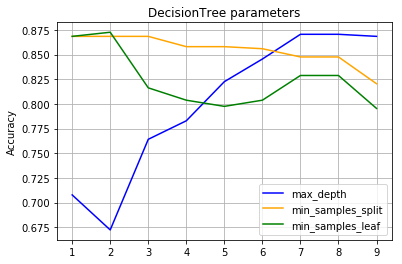

In [455]:
plt.plot(np.arange(1, 10), ttt_depth, color="blue", label="max_depth")
plt.plot(np.arange(1, 10), ttt_split, color="orange", label="min_samples_split")
plt.plot(np.arange(1, 10), ttt_leaf, color="green", label="min_samples_leaf")
    
plt.title("DecisionTree parameters")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

__15. (1 балл)__ #done

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [325]:
ttt = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data', names=np.hstack((np.arange(1, 10).astype(np.string_), np.array(['result']))))
ttt_target = np.array(ttt[ttt.columns[-1]])
ttt_data = np.array(ttt[ttt.columns[:-1]])

ttt_target = lab_enc.fit_transform(ttt_target)

for i in range(ttt_data.shape[1]):
    ttt_data[:, i] = lab_enc.fit_transform(ttt_data[:, i])

In [327]:
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=np.hstack((np.arange(1, 7).astype(np.string_), np.array(['quality']))))
cars.quality.replace(to_replace=dict(unacc=0, acc=0, good=1, vgood=1), inplace=True)

cars_target = np.array(cars[cars.columns[-1]])
cars_data = np.array(cars[cars.columns[:-1]])

cars_target = lab_enc.fit_transform(cars_target)

for i in range(cars_data.shape[1]):
    cars_data[:, i] = lab_enc.fit_transform(cars_data[:, i])

In [329]:
nur = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', names=np.hstack((np.arange(1, 9).astype(np.string_), np.array(['state']))))
nur.state.replace(to_replace=dict(not_recom=0, recommend=0, very_recom=1, priority=1, spec_prior=1), inplace=True)

nur_target = np.array(nur[nur.columns[-1]])
nur_data = np.array(nur[nur.columns[:-1]])

nur_target = lab_enc.fit_transform(nur_target)

for i in range(nur_data.shape[1]):
    nur_data[:, i] = lab_enc.fit_transform(nur_data[:, i])

In [356]:
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score

cv = KFold(n=data.shape[0], n_folds=10)
acc_scorer = make_scorer(accuracy_score)
#scv = KFold(n=ohe_mushrooms_design.shape[0], n_folds=10, shuffle=True, random_state=42)
mr1 = cross_val_score(DecisionTree(["real"] * data.shape[1]), data, target, scoring=acc_scorer, cv=cv).mean()

In [361]:
mr2 = cross_val_score(DecisionTree(["categorical"] * data.shape[1]), data, target, scoring=acc_scorer, cv=cv).mean()
mr2

1.0

In [367]:
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(sparse=False)

one_hot_data = one_hot.fit_transform(data)
mr3 = cross_val_score(DecisionTree(["real"] * one_hot_data.shape[1]), one_hot_data, target, scoring=acc_scorer, cv=cv).mean()
mr3

0.99963054187192113

In [369]:
clf = DecisionTreeClassifier()
mr4 = cross_val_score(clf, data, target, scoring=acc_scorer, cv=cv).mean()
mr4

0.99876847290640391

In [372]:
df_tree = pd.DataFrame(columns=["Custom Categorical", "Custom Real", "Custom One-Hot Real", "Sklearn"],
                       index=["mushrooms", "tic-tac-toe", "cars", "nursery"])

In [375]:
df_tree.loc['mushrooms'] = [mr1, mr2, mr3, mr4]

In [404]:
cv = KFold(n=ttt_data.shape[0], n_folds=10)
t1 = cross_val_score(DecisionTree(["real"] * ttt_data.shape[1]), ttt_data, ttt_target, scoring=acc_scorer, cv=cv).mean()
t2 = cross_val_score(DecisionTree(["categorical"] * ttt_data.shape[1]), ttt_data, ttt_target, scoring=acc_scorer, cv=cv).mean()
one_hot_data = one_hot.fit_transform(ttt_data)
t3 = cross_val_score(DecisionTree(["real"] * one_hot_data.shape[1]), one_hot_data, ttt_target, scoring=acc_scorer, cv=cv).mean()
t4 = cross_val_score(clf, ttt_data, ttt_target, scoring=acc_scorer, cv=cv).mean()

In [406]:
df_tree.loc['tic-tac-toe'] = [t1, t2, t3, t4]

In [410]:
cv = KFold(n=cars_data.shape[0], n_folds=10)
c1 = cross_val_score(DecisionTree(["real"] * cars_data.shape[1]), cars_data, cars_target, scoring=acc_scorer, cv=cv).mean()
c2 = cross_val_score(DecisionTree(["categorical"] * cars_data.shape[1]), cars_data, cars_target, scoring=acc_scorer, cv=cv).mean()
one_hot_data = one_hot.fit_transform(cars_data)
c3 = cross_val_score(DecisionTree(["real"] * one_hot_data.shape[1]), one_hot_data, cars_target, scoring=acc_scorer, cv=cv).mean()
c4 = cross_val_score(clf, cars_data, cars_target, scoring=acc_scorer, cv=cv).mean()

In [412]:
df_tree.loc['cars'] = [c1, c2, c3, c4]

In [414]:
cv = KFold(n=nur_data.shape[0], n_folds=10)

In [417]:
n1 = cross_val_score(DecisionTree(["real"] * nur_data.shape[1]), nur_data, nur_target, scoring=acc_scorer, cv=cv).mean()
n2 = cross_val_score(DecisionTree(["categorical"] * nur_data.shape[1]), nur_data, nur_target, scoring=acc_scorer, cv=cv).mean()
one_hot_data = one_hot.fit_transform(nur_data)
n3 = cross_val_score(DecisionTree(["real"] * one_hot_data.shape[1]), one_hot_data, nur_target, scoring=acc_scorer, cv=cv).mean()
n4 = cross_val_score(clf, nur_data, nur_target, scoring=acc_scorer, cv=cv).mean()

In [419]:
df_tree.loc['nursery'] = [n1, n2, n3, n4]

In [420]:
df_tree

,Custom Categorical,Custom Real,Custom One-Hot Real,Sklearn
mushrooms,0.999261,1,0.999631,0.998768
tic-tac-toe,0.467533,0.541458,0.543575,0.46864
cars,1,1,1,1
nursery,0.999691,0.999691,0.999537,0.999691


__16. (0.5 балла)__ #done

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**


В целом алгоритмы по-разному ранжируются на различных наборах данных, хотя более-менее показательные результаты только на первых двух датасетах, последние два оказались слишком простыми для алгоритмов (первый тоже, но там хотя бы везде разные значения accuracy), и на них все алгоритмы показали хорошие результаты. Я думаю, что алгоритмы ранжируются по-разному из-за разных значений признаков в разных наборах данных. Да, есть компонента случайности, можно кодировать категориальные признаки по-разному.

### III. Композиции деревьев
#### Задача 4. Сравнение композиционных методов над решающими деревьями
__17. (0.5 балла)__ #done

Загрузите датасет из соревнования [BNP Paribas Cardif Claims Management](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/leaderboard). Возьмите из него первые 10к объектов, оставьте только вещественные признаки, а пропуски замените нулями. Разбейте выборку на обучение и контроль в соотношении 7:3.

1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов на обучающей выборке:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом (если это не так, то посмотрите как ведут себя алгоритмы с разными сидами в кроссвалидации и самих алгоритмах). Этот пример демонстрирует, что RandomForest — это более сложный алгоритм, чем бэггинг. 

In [456]:
bnp = pd.read_csv('train.csv')
bnp.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [463]:
bnp = bnp.fillna(0)

In [496]:
nonreal = []
for col in bnp.columns:
    try:
        bnp.iloc[1][col] + 1
    except:
        nonreal.append(col)

In [497]:
for col in nonreal:
    del bnp[col]

In [471]:
del bnp['ID']

In [472]:
bnp.head()

,target,v1,v2,v4,v5,v6,v7,v8,v9,v10,...,v121,v122,v123,v124,v126,v127,v128,v129,v130,v131
0,1,1.335739,8.727474,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,...,0.803572,8.000000,1.989780,0.035754,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,1,0.000000,0.000000,0.000000,9.191265,0.000000,0.000000,2.301630,0.000000,1.312910,...,0.000000,0.000000,0.000000,0.598896,0.000000,0.000000,1.957825,0,0.000000,0.000000
2,1,0.943877,5.310079,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,...,2.238806,9.333333,2.477596,0.013452,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,1,0.797415,8.304757,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,...,1.956521,7.018256,1.812795,0.002267,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.050328,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000


In [498]:
bnp_target = np.array(bnp[:10000][bnp.columns[0]])
bnp_data = np.array(bnp[:10000][bnp.columns[1:]])

In [516]:
X_train, X_test, y_train, y_test = train_test_split(bnp_data, bnp_target, test_size=0.3, random_state=42)

In [501]:
cv = KFold(n=bnp_data.shape[0], n_folds=3)
acc_scorer = make_scorer(accuracy_score)
acc = cross_val_score(DecisionTreeClassifier(), bnp_data, bnp_target, scoring=acc_scorer, cv=cv).mean()

In [502]:
acc

0.66260105314670648

In [503]:
from sklearn.ensemble import BaggingClassifier
acc = cross_val_score(BaggingClassifier(n_estimators=100), bnp_data, bnp_target, scoring=acc_scorer, cv=cv).mean()

In [504]:
acc

0.7527998150744889

In [506]:
from sklearn.ensemble import RandomForestClassifier
acc = cross_val_score(RandomForestClassifier(n_estimators=100), bnp_data, bnp_target, scoring=acc_scorer, cv=cv).mean()

In [507]:
acc

0.7540001450654964

#### Задача 5. Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__18. (0.5 балла)__ #done

Переберите значения от 20 до 1000-5000 деревьев с шагом 20, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $20 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев? Судя по графику, есть тенденция на спад точности, но она достаточно неуверенная.

In [522]:
tree_range = np.arange(20, 5021, 20)
tree_res = []

clf = RandomForestClassifier(n_estimators=20, warm_start=True)

for i, ran in enumerate(tree_range[:-1]):
    clf.fit(X_train, y_train)
    tree_res.append(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
    clf.set_params(n_estimators=tree_range[i + 1])
    if ran % 500 == 0:
        print(str(int(ran / 50.0)) + "% done")

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done


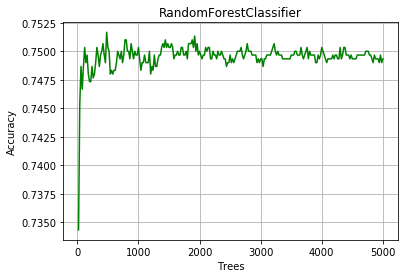

In [524]:
plt.plot(tree_range[:-1], tree_res, color="green")
    
plt.title("RandomForestClassifier")
plt.ylabel("Accuracy")
plt.xlabel("Trees")
plt.grid()
plt.legend()

#### Задача 6. Обучение градиентного бустинга

__19. (1 балл)__ #done

А теперь попробуйте обучить на тех же данных xgboost — одну из реализаций градиентного бустинга. Подберите параметры на обучающем множестве с помощью кроссвалидации (хорошая [статья](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) про тюнинг параметров xgboost). 

In [541]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [542]:
accuracy_score(y_pred=model.predict(X_test), y_true=y_test)

0.7593333333333333

In [546]:
model.get_xgb_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': 1,
 'subsample': 1}

Источник -- статья из условия задания.

In [554]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4


def modelfit(alg, X_train, y_train, predictors, cv_folds=5, early_stopping_rounds=50):
    
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='error', early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])
    
    alg.fit(X_train, y_train, eval_metric='error')
        
    dtrain_predictions = alg.predict(X_train)
        
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8204


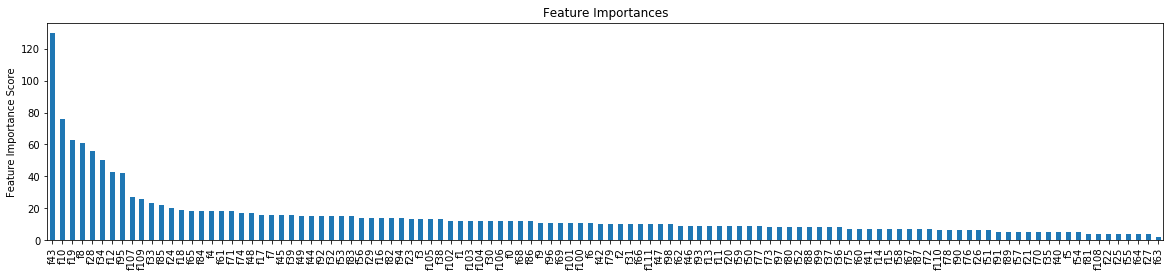

In [555]:
predictors = [X_train[:,i] for i in range(X_train.shape[1])]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, X_train, y_train, predictors)

In [577]:
param_test1 = {
 'max_depth': np.arange(3,10,2),
 'min_child_weight': np.arange(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [581]:
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=7, min_child_weight=5)
model.fit(X_train, y_train)
accuracy_score(y_pred=model.predict(X_test), y_true=y_test)

0.76166666666666671

__20. (бонус, 1 балл)__

_В этом и следующем бонусе можете использовать либо теже 10к первых объектов, либо полную выборку._

Теперь вспомним, что изначально выбросили все категориальные признаки из датасета. Добавьте категориальные признаки с количеством уникальных значений < 50 тремя способами:
* как OHE признаки
* как порядковые признаки (закодируйте с помощью LabelEncoder, порядок случайный)
* как счетчики со сглаживанием

Подберите в каждом из случаев оптимальные параметры метода. Как вы думаете, должна ли меняться оптимальная глубина деревьев от способа кодирования категориальных признаков? Согласуется ли это с экспериментом? Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? 

__21. (бонус, 1 балл)__

Попробуйте пообучать на этих же данных другие реализации градиентного бустинга – catboost и lgbm. Подберите для них оптимальные параметры. Удалось ли достичь качества лучше, чем у xgboost? Сравните время обучения всех трех реализаций.

### IV. P. S.
Если вы добрались до этой ячейки, то скорее всего, вы очень устали и хотите... впрочем, каждый в данной ситуации хочет что-то свое :) Так или иначе, здесь вы можете написать фидбек по заданию: указать, с чем возникли проблемы, что оказалось самым сложным, а что — простым, как можно усовершенствовать задание в будущем. Или просто поделитесь мнением о том, какой фактор будет самым важным при сдаче экзамена по курсу.

__22. (бонус, 0.2 балла)__ А еще, вставьте нарисованную вами смешную картинку. <a id='return'></a>

(・・ ) ? Нарисованные мной я вставляла выше куда-то [сюда](#hello_cat) и [сюда](#another_cat). Вот ещё попугайчик, но он не мой.

In [533]:
sirocco()




                                       `:i+zzzz+*;,`                                                                              
                                    ,+M############@x+:                                                                           
                                 `*M###################W+.                                                                        
                               `+@#######@MxnnnnxM@######@z.                                                                      
                              ;W#####Wn+i;;;;;;;;;;*zM#####@#`                                                                    
                            `#####@x*;;;;;;;;;;;;;;;;;*n@####M,                                                                                                                                 
                         .W###Mi;;;;;;;;;;;;;;;;;;;;;;;;;;;;#####i                                                                
                  